# Setup

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/var/folders/cn/qh1c0kgs1y7bqdlpqd82cpqc0000gn/T/ipykernel_52212/1536809154.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [18]:
procs_added = pd.read_csv("procs_added.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "actualComp", "migrated"])
procs_current = pd.read_csv("procs_current.txt", index_col=None, names=["tick", "machineID", "sla", "actualComp", "compDone"])
procs_done = pd.read_csv("procs_done.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "ticksPassed", "actualComp", "timesReplenished"])
procs_killed = pd.read_csv("procs_killed.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "memUsed"])

sched_decisions = pd.read_csv("sched.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "ticksPassed", "ticksGiven", "done"])


# Overview takeaways

In [19]:
# prepare
all_procs = pd.concat([procs_current[['tick']], procs_added[["tick"]]])
load_per_tick = all_procs[["tick"]].groupby("tick").size().reset_index(name='numProcsCurrent')

procs_done['pctLate'] = (procs_done["ticksPassed"] - procs_done["sla"]) / procs_done["sla"]

procs_late = procs_done.where(procs_done["ticksPassed"] > procs_done["sla"]).dropna().reset_index(drop=True)
procs_late = procs_late.where(procs_late["ticksPassed"] > procs_late["actualComp"]).dropna().reset_index(drop=True)

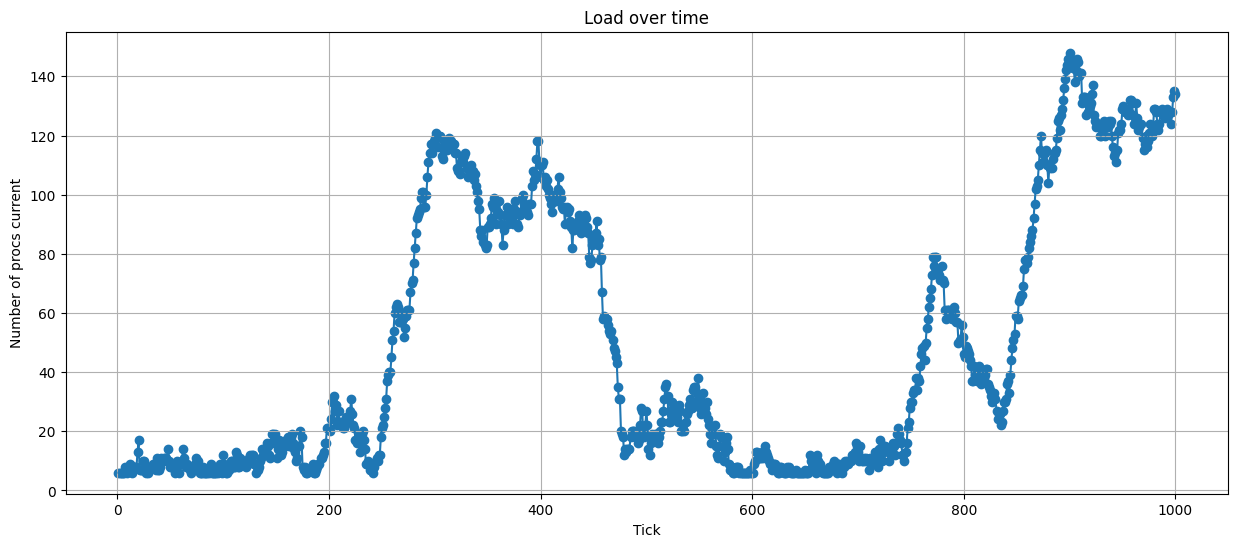

In [20]:
# load over time

plt.figure(figsize=(15,6))
plt.scatter(load_per_tick["tick"], load_per_tick["numProcsCurrent"])
plt.plot(load_per_tick["tick"], load_per_tick["numProcsCurrent"])

plt.title('Load over time')
plt.xlabel('Tick')
plt.ylabel('Number of procs current')
plt.grid(True)
plt.show()


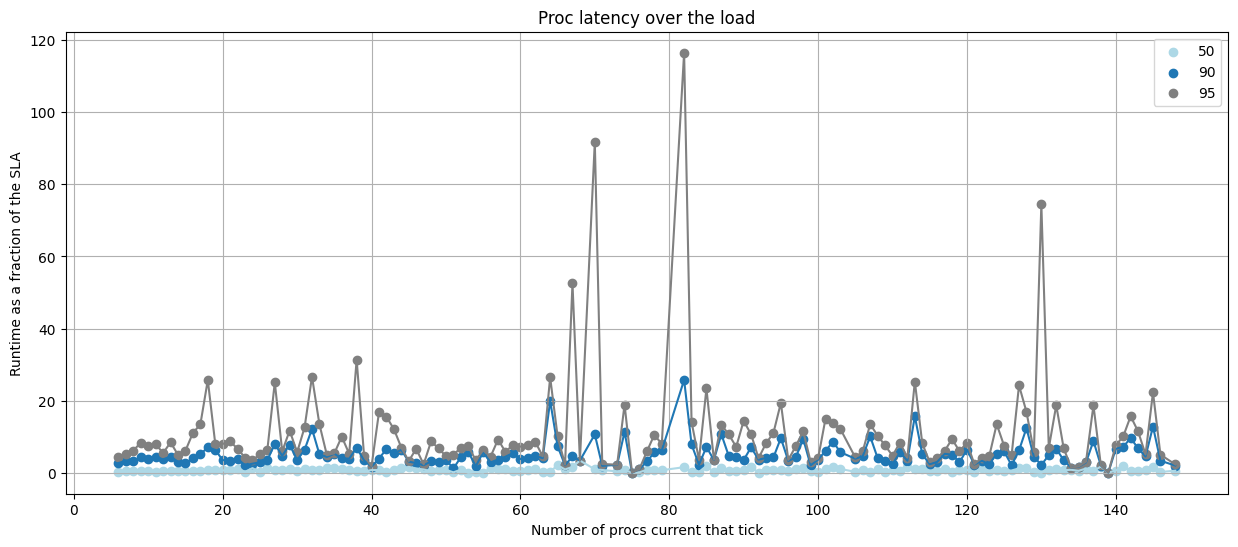

In [21]:
# Proc latency (as a percentage of their SLA) over the load (number of procs currently live)

proc_timings = pd.merge(procs_done, load_per_tick, on='tick', how='left')

def get_percentile(pctile):
    return proc_timings[["numProcsCurrent", "pctLate"]].groupby("numProcsCurrent").quantile(pctile / 100).reset_index()

plt.figure(figsize=(15,6))

plt.scatter(get_percentile(50)["numProcsCurrent"], get_percentile(50)["pctLate"], color='lightblue', label="50")
plt.plot(get_percentile(50)["numProcsCurrent"], get_percentile(50)["pctLate"], color='lightblue')

plt.scatter(get_percentile(90)["numProcsCurrent"], get_percentile(90)["pctLate"], label="90")
plt.plot(get_percentile(90)["numProcsCurrent"], get_percentile(90)["pctLate"])

plt.scatter(get_percentile(95)["numProcsCurrent"], get_percentile(95)["pctLate"], color='grey', label="95")
plt.plot(get_percentile(95)["numProcsCurrent"], get_percentile(95)["pctLate"], color='grey')

plt.xlabel('Number of procs current that tick')
plt.ylabel('Runtime as a fraction of the SLA')
plt.title('Proc latency over the load')
plt.grid(True)
plt.legend()
plt.show()



In [22]:
proc_timings.where(proc_timings["pctLate"] > 100).dropna()

,tick,machineID,procType,sla,ticksPassed,actualComp,timesReplenished,pctLate,numProcsCurrent
265,47.0,1.0,page static,0.005590,0.969200,0.005561,0.0,172.393198,10.0
298,52.0,1.0,page static,0.000861,0.679743,0.000772,0.0,788.647349,9.0
394,68.0,1.0,page static,0.003277,0.389684,0.003587,1.0,117.923069,8.0
898,153.0,1.0,page static,0.007403,0.970395,0.007703,1.0,130.073038,17.0
1028,174.0,1.0,page static,0.007466,0.761943,0.007153,0.0,101.059304,18.0
1208,207.0,0.0,page dynamic,0.001155,0.365276,0.001057,0.0,315.157612,29.0
1592,277.0,1.0,page dynamic,0.003084,0.989625,0.003032,0.0,319.926784,67.0
1799,320.0,0.0,page static,0.003755,0.759053,0.003238,0.0,201.148031,114.0
1941,341.0,0.0,page static,0.002451,0.372198,0.002513,1.0,150.870689,98.0
2002,348.0,1.0,page static,0.004120,0.856894,0.003864,0.0,206.987183,82.0


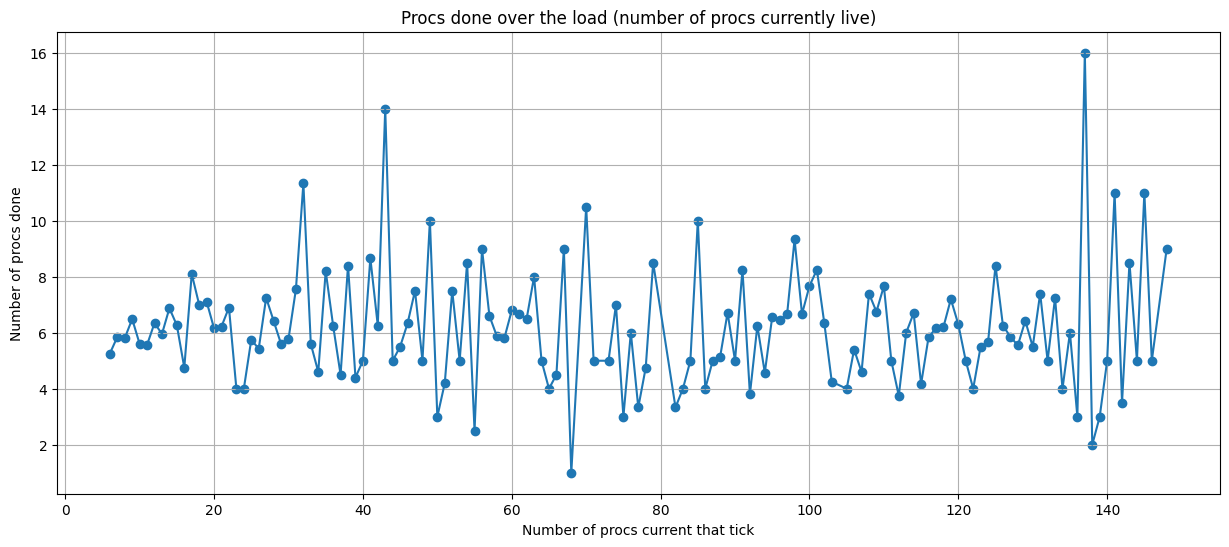

In [23]:
# Procs done over the load (number of procs currently live)
 
num_done = procs_done[["tick"]].groupby("tick").size().reset_index(name='numProcsDone')

merged_done_added = pd.merge(num_done, load_per_tick, on='tick', how='left')

avg_done = merged_done_added[["numProcsCurrent", "numProcsDone"]].groupby("numProcsCurrent").mean().reset_index()

plt.figure(figsize=(15,6))
plt.scatter(avg_done["numProcsCurrent"], avg_done["numProcsDone"])
plt.plot(avg_done["numProcsCurrent"], avg_done["numProcsDone"])

plt.title('Procs done over the load (number of procs currently live)')
plt.xlabel('Number of procs current that tick')
plt.ylabel('Number of procs done')
plt.grid(True)
plt.show()

In [97]:
# procs late
avg_pct_late = procs_late['pctLate'].mean()
num_procs_late = procs_late.shape[0]
print("procs late: " + str(num_procs_late))
print("avg pct late: " + str(avg_pct_late))

# procs killed
num_procs_killed = procs_killed.shape[0]
print("procs killed: " + str(num_procs_killed))

procs late: 2151
avg pct late: 21.10804083816433
procs killed: 0


# Procs late overview

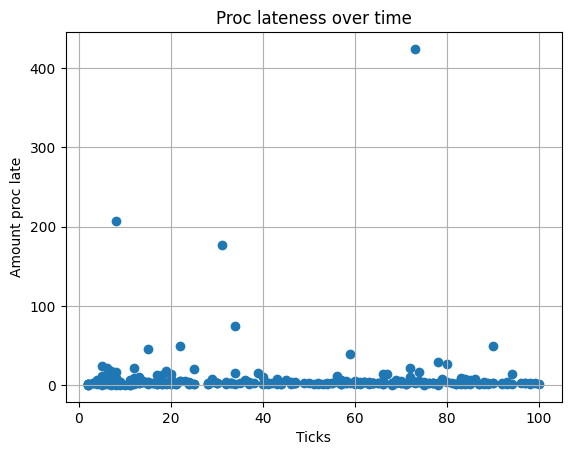

In [60]:
# plot by tick
plt.scatter(procs_late["tick"], procs_late['pctLate'].values)
plt.xlabel('Ticks')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over time')
plt.grid(True)
plt.show()

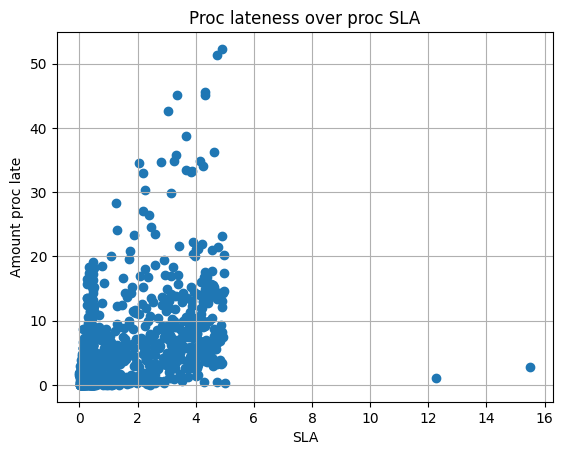

In [97]:
# plot by SLA
plt.scatter(procs_late["sla"], procs_late['amountLate'].values)
plt.xlabel('SLA')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over proc SLA')
plt.grid(True)
plt.show()

# Procs killed overview

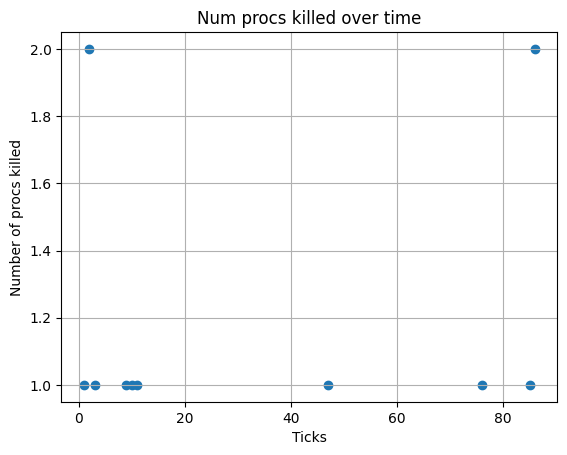

In [98]:
# plot by tick
ticks_procs_killed = procs_killed[["tick"]].groupby("tick").size().reset_index(name='counts')
ticks_procs_killed

plt.scatter(ticks_procs_killed["tick"], ticks_procs_killed['counts'].values)
plt.xlabel('Ticks')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

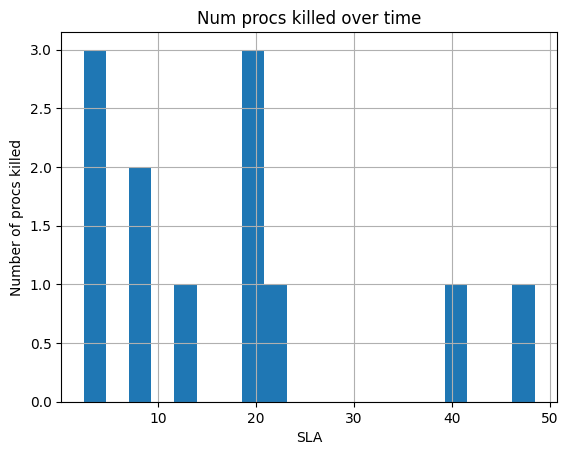

In [102]:
# plot by SLA
plt.hist(procs_killed["sla"], bins=20)
plt.xlabel('SLA')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

# Utilization Overview

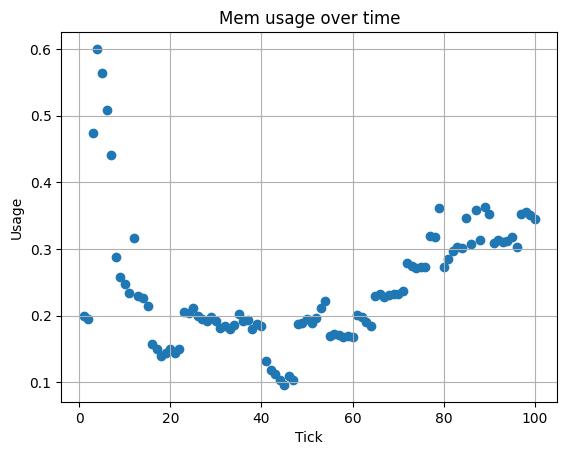

In [121]:
# plot memory usage over time
grouped = active_machines_usage.groupby('tick')["memUsage"].mean().reset_index()
# grouped["tick"]
plt.scatter(grouped["tick"], grouped["memUsage"])
plt.xlabel('Tick')
plt.ylabel('Memory Usage')
plt.title('Mem usage over time')
plt.grid(True)
plt.show()

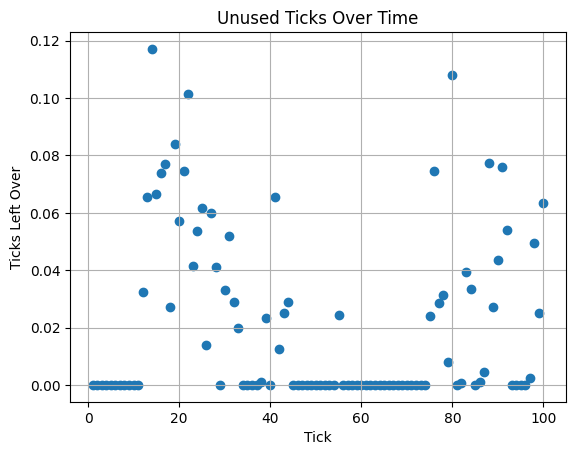

In [123]:
# plot ticks left over, over time
grouped = active_machines_usage.groupby('tick')["unusedTicks"].mean().reset_index()
# grouped["tick"]
plt.scatter(grouped["tick"], grouped["unusedTicks"])
plt.xlabel('Tick')
plt.ylabel('Ticks Left Over')
plt.title('Unused Ticks Over Time')
plt.grid(True)
plt.show()